# Μέρος 1. Ψυχοακουστικό Μοντέλο

#### Οι Ασκήσεις πραγματοποιήθηκαν από τους : ΒΑΣΙΛΕΙAΔΗΣ ΔΗΜΉΤΡΙΟΣ AM: 03122111/el22111 - ΓΡΗΓΟΡΙΟΣ ΣΤΑΜΑΤΟΠΟΥΛΟΣ ΑΜ: 03122039/el22039.        Η Βιβλιογραφία μας αποτελείται από:
* Το documentation όλων των διαθέσιμων βιβλιοθηκών που αναφέρονται στο αρχείο "PYTHON GUIDE" στη διαδασκαλική ιστοσελίδα του Helios, 
* Όλα τα σετ διαφανειών που είναι ανεβασμένα στην παραπάνω ιστοσελίδα,
* Καθώς και πληροφορίες από δίαφορες άλλες όπως:


    *  https://dsp.stackexchange.com/ , 
    *  https://stackoverflow.com/search?q=jupyter+notebook , 
    *  https://ieeexplore.ieee.org/Xplore/home.jsp , 
    *  https://www.wikipedia.org/ , 
    *  https://arxiv.org/abs/2306.08436 , 
    *  https://sites.google.com/berkeley.edu/ee123-sp20/python , 
    *  https://github.com/openlists/DSPResources και άλλες ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf  # Για αποθήκευση σε .wav
from IPython.display import Audio, display
import librosa
import scipy.signal as sig

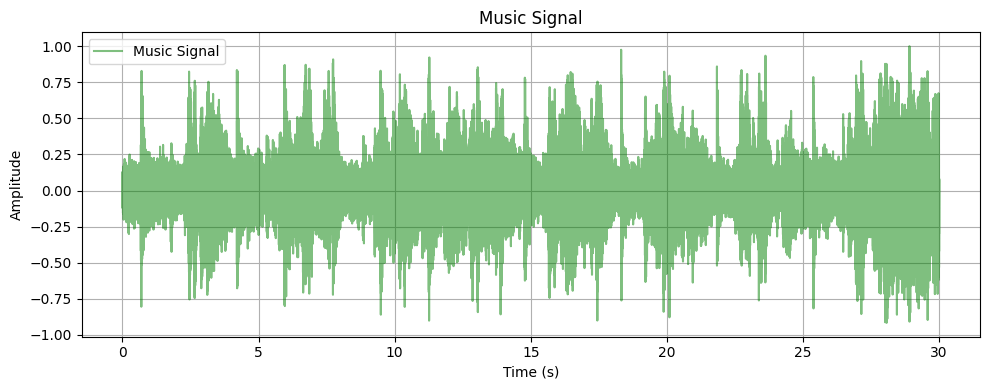

Συνολικά πλαίσια: 2583


In [2]:
# Βήμα 1.1. Φόρτωση του σήματος (υποθέτουμε ότι το αρχείο "speech utterance.wav" βρίσκεται στο κατάλληλο path)
audio_path = 'DSP25_LabProject2_Material/music_dsp.wav'
audio_signal, sr = librosa.load(audio_path, sr=44100,  mono=True)  

# Κανονοποιούμε το σήμα
audio_signal = audio_signal / np.max(np.abs(audio_signal))

N = 512

# Παραθυροποιούμε το σήμα χρησιμοποιώντας παραθυρο Hann
frames = librosa.util.frame(audio_signal, frame_length=N, hop_length=N)

# Το εφαρμόζουμε σε κάθε frame
han_window = np.hanning(N)
frames_windowed = frames * han_window[:, np.newaxis]


# Plot of the music signal
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(audio_signal)) / sr, audio_signal, label='Music Signal', color='g', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Music Signal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

num_frames = len(audio_signal) // N
print(f"Συνολικά πλαίσια: {num_frames}")




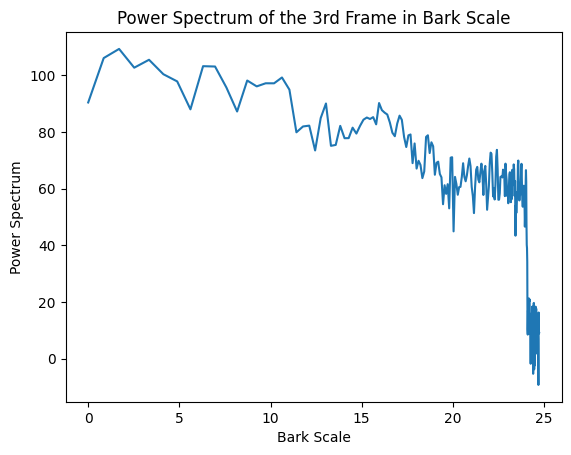

C:\Users\User\AppData\Local\Temp\ipykernel_18456\3525271348.py:34: RuntimeWarning: divide by zero encountered in power
  Tq = 3.64*(freqs/1000)**(-0.8) - 6.5*np.exp(-0.6*((freqs/1000)-3.3)**2) + 1e-3*(freqs/1000)**4


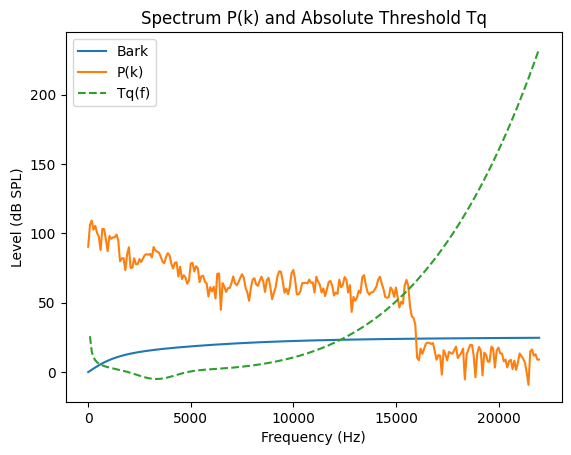

In [3]:
# 1.1 Υπολογισμός κλίμακας Bark και Μονόπλευρου Φάσματος Ισχύος

def bark(f):
    return 13*np.arctan(0.00076*f) + 3.5*np.arctan((f/7500)**2)

def compute_power_spectrum(frame):
    PN = 90.302

    # Υπολογίζουμε τον fft του frame
    signal_fft = np.fft.rfft(frame) # FFT μονοπλευρής εξόδου (257 σημεία) - δεξιά fft

    signal_dB = 10*np.log10(np.abs(signal_fft)**2)

    power_spectrum = PN + signal_dB

    spectrum =  power_spectrum[:256] # αγνοούμε το τελευταίο σημείο (Nyquist) για 256 σημεία
    return spectrum

# Παρουσιάζουμε το φάσμα ισχύος

frame_idx = 3
x_frame = frames_windowed[:, frame_idx - 1]
frame_spectrum = compute_power_spectrum(x_frame)
freqs = np.arange(256) * sr / N
bark_freq = bark(freqs)

# Plots
plt.plot(bark_freq, frame_spectrum)
plt.xlabel('Bark Scale')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum of the 3rd Frame in Bark Scale')
plt.show()

Tq = 3.64*(freqs/1000)**(-0.8) - 6.5*np.exp(-0.6*((freqs/1000)-3.3)**2) + 1e-3*(freqs/1000)**4

# --- Plot 1: Spectrum and Tq ---
plt.figure()
plt.plot(freqs, bark_freq, label='Bark')
plt.plot(freqs, frame_spectrum, label='P(k)')
plt.plot(freqs, Tq, linestyle='--', label='Tq(f)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Level (dB SPL)')
plt.title('Spectrum P(k) and Absolute Threshold Tq')
plt.legend()
plt.show()

In [4]:
# Φόρτωση των προϋπολογισμένων πινάκων μασκών (tonal, noise maskers)
P_TMc = np.load('DSP25_LabProject2_Material/P_TMc-25.npy')   # τονικές μάσκες (μετά τη μείωση)
P_NMc = np.load('DSP25_LabProject2_Material/P_NMc-25.npy')   # μάσκες θορύβου (μετά τη μείωση)
P_NM  = np.load('DSP25_LabProject2_Material/P_NM-25.npy')    # αρχικές μάσκες θορύβου (πριν τη μείωση)

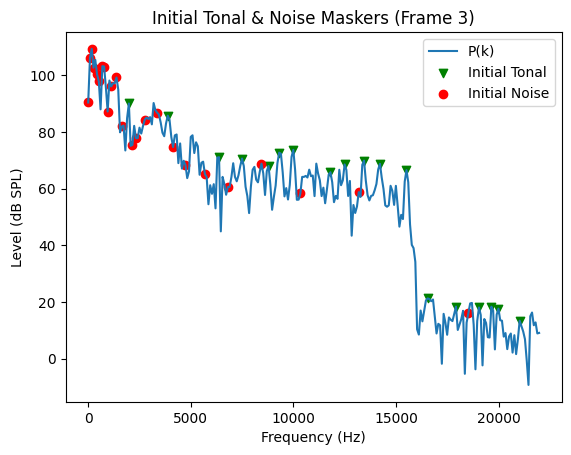

In [5]:
# 1.2  Εντοπισμός μασκών τόνων και θορύβου (Maskers)


# Εύρος αναζήτησης για κάθε περιοχή συχνοτήτων
def delta_k(k):
    if 2 <= k < 63:
        return [2]
    elif 63 <= k < 127:
        return [2, 3]
    elif 127 <= k < 250:
        return [2, 3, 4, 5, 6]
    else:
        return []

# Συνάρτηση ST(k) — Boolean πίνακας με τονικές μάσκες
ST = np.zeros_like(frame_spectrum, dtype=bool)
for k in range(2, min(len(frame_spectrum)-1, 250)):
    dk = delta_k(k)
    is_local_max = frame_spectrum[k] > frame_spectrum[k-1] and frame_spectrum[k] > frame_spectrum[k+1]
    for delta in dk:
        if k - delta < 0 or k + delta >= len(frame_spectrum):
            continue
        is_mask = is_local_max and (frame_spectrum[k] > frame_spectrum[k - delta] + 7) and (frame_spectrum[k] > frame_spectrum[k + delta] + 7)
        if is_mask:
            ST[k] = True
            break 
# Υπολογισμός PTM(k) — Ισχύς τονικών μασκών
PTM = np.zeros_like(frame_spectrum)
for k in range(1, len(frame_spectrum)-1):
    if ST[k]:
        PTM[k] = 10 * np.log10(
            10**(0.1 * frame_spectrum[k-1]) + 10**(0.1 * frame_spectrum[k]) + 10**(0.1*frame_spectrum[k+1])
        )

# --- 4. Initial tonal maskers detection ---

initial_tonal_idx = np.where(PTM > 0)[0]
initial_noise_idx = np.where(P_NM[:256, frame_idx] > 0)[0]

plt.figure()
plt.plot(freqs, frame_spectrum, label='P(k)')
plt.scatter(freqs[initial_tonal_idx], frame_spectrum[initial_tonal_idx], marker='v', label='Initial Tonal', color = 'g')
plt.scatter(freqs[initial_noise_idx], frame_spectrum[initial_noise_idx], marker='o', label='Initial Noise', color = 'r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Level (dB SPL)')
plt.title('Initial Tonal & Noise Maskers (Frame 3)')
plt.legend()
plt.show()



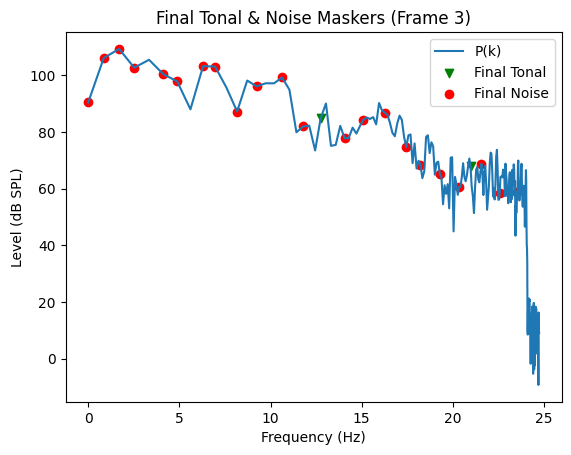

In [6]:
# 1.3 Μείωση και αναδιοργάνωση των μασκών

#Βρίσκουμε τις μάσκες από τους έτοιμους πίνακες

final_tonal_idx = np.where(P_TMc[:256, frame_idx] > 0)[0]
final_noise_idx = np.where(P_NMc[:256, frame_idx] > 0)[0]

# Αποτελέσματα
plt.figure()
plt.plot(bark_freq, frame_spectrum, label='P(k)')
plt.scatter(bark_freq[final_tonal_idx], frame_spectrum[final_tonal_idx], marker='v', label='Final Tonal', color = 'g')
plt.scatter(bark_freq[final_noise_idx], frame_spectrum[final_noise_idx], marker='o', label='Final Noise', color = 'r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Level (dB SPL)')
plt.title('Final Tonal & Noise Maskers (Frame 3)')
plt.legend()
plt.show()

In [7]:
# Step 1.4: Υπολογισμός των δυο διαφορετικών κατωφλίων κάλυψης (Individual Masking Thresholds)


def Tq(frame):
    tq = np.zeros(len(frame))

    for f in range(1, len(frame)):
        tq[f] = 3.64 * (f / 1000) ** -0.8 - 6.5 * np.exp(-0.6 * (f / 1000 - 3.3) ** 2) + 10 ** -3 * (f / 1000) ** 4
    return tq

In [8]:
def sf(pm):
    sf = np.zeros((len(pm), len(pm)))

    for j in range(0, len(pm)):
        if pm[j] > 0:
            for i in range (0, len(pm)):
                diff = bark(i) - bark(j)
                if -3 <= diff < -1:
                    sf[i][j] = 17*diff - 0.4*pm[j] + 11
                if -1 <= diff < 0:
                    sf[i][j] = (0.4*pm[j] + 6)*diff
                if 0 <= diff < 1:
                    sf[i][j] = -17*diff
                if 1 <= diff < 8:
                    sf[i][j] = (0.15*pm[j] - 17)*diff -0.15*pm[j]
    return sf

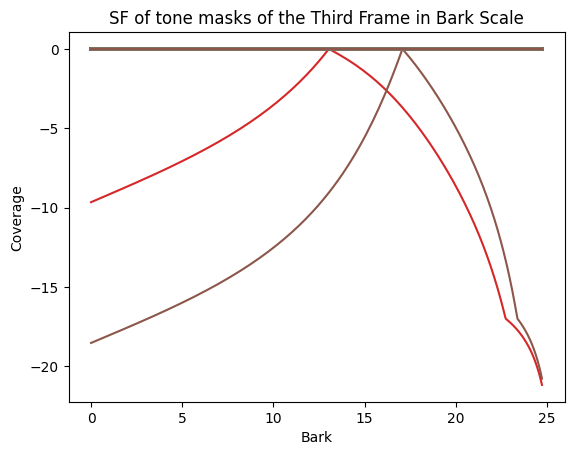

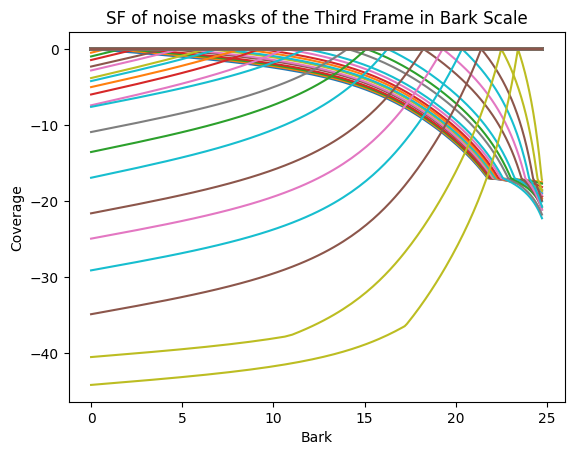

In [9]:
# Plot ST για το τρίτο framew

# Τρίτο frame από το PTMc table
PTMc_thrd = P_TMc[:, 2]

#Τρίτο frame από το PNMc table
PNMc_thrd = P_NMc[:, 2]

# Υπολογισμός Tq για το τρίτο frame
thrd_frame_ps = compute_power_spectrum(frames_windowed[:,2])
tq_thrd = Tq(thrd_frame_ps)

# SF τονικής μάσκας για το τρίτο frame
sf_tm = sf(PTMc_thrd)

freqs_sf_tm = np.arange(len(sf_tm)) * (sr / N)

# Μετατροπή συχνότητας σε Bark scale
bark_scale_sf_tm = bark(freqs_sf_tm)

# SF μάσκας θορύβου για το τρίτο frame
sf_nm = sf(PNMc_thrd)

freqs_sf_nm = np.arange(len(sf_nm)) * (sr / N)

# Μετατροπή συχνότητας σε Bark scale
bark_scale_sf_nm = bark(freqs_sf_nm)

# Plot SF τονικής μάσκας σε Bark scale
plt.plot(bark_scale_sf_tm, sf_tm)

# Set labels and show plot
plt.xlabel('Bark')
plt.ylabel('Coverage')
plt.title('SF of tone masks of the Third Frame in Bark Scale')
plt.show()

# Plot SF μάσκας θορύβου σε Bark scale
plt.plot(bark_scale_sf_nm, sf_nm)

# show plot
plt.xlabel('Bark')
plt.ylabel('Coverage')
plt.title('SF of noise masks of the Third Frame in Bark Scale')
plt.show()


In [10]:
def ttm(sf, ptm):
    ttm = np.zeros((len(ptm), len(ptm)))

    for j in range(0, len(ptm)):
        for i in range (0, len(ptm)):
            ttm[i][j] = ptm[j] - 0.275*bark(j) + sf[i][j] - 6.025

    return ttm

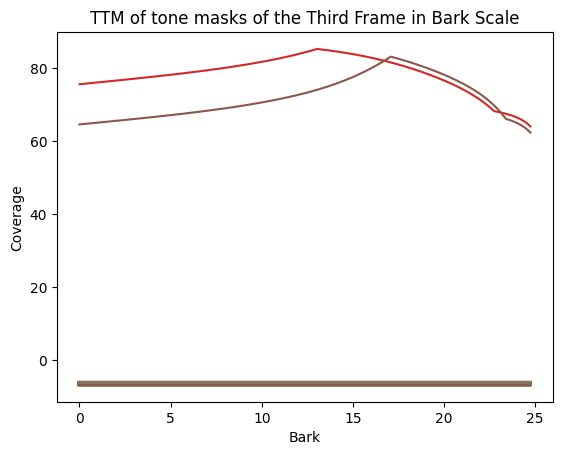

In [11]:
# Υπολογισμός ttm για το τρίτο frame
ttm_thrd = ttm(sf_tm, PTMc_thrd)

freqs_ttm_thrd = np.arange(len(ttm_thrd)) * (sr / N)

# Μετατροπή συχνότητας σε Bark scale
bark_scale_ttm_thrd = bark(freqs_ttm_thrd)

# Plot TTM τονικής μάσκας σε Bark scale
plt.plot(bark_scale_ttm_thrd, ttm_thrd)

# Set labels and show plot
plt.xlabel('Bark')
plt.ylabel('Coverage')
plt.title('TTM of tone masks of the Third Frame in Bark Scale')
plt.show()


In [12]:
def tnm(sf, pnm):
    tnm = np.zeros((len(pnm), len(pnm)))

    for j in range(0, len(pnm)):
        for i in range (0, len(pnm)):
            tnm[i][j] = pnm[j] - 0.175*bark(j) + sf[i][j] - 2.025

    return tnm


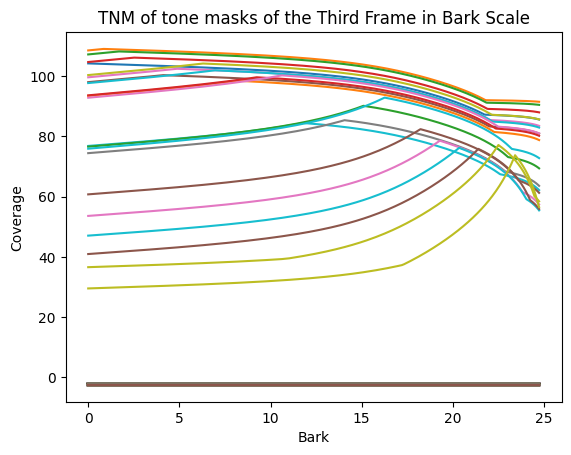

In [13]:
# Υπολογισμός tnm για το τρίτο frame
tnm_thrd = tnm(sf_nm, PNMc_thrd)

freqs_tnm_thrd = np.arange(len(tnm_thrd)) * (sr / N)

# Μετατροπή συχνότητας σε Bark scale
bark_scale_tnm_thrd = bark(freqs_tnm_thrd)

# Plot TTM τονικής μάσκας σε Bark scale
plt.plot(bark_scale_tnm_thrd, tnm_thrd)

# Set labels and show plot
plt.xlabel('Bark')
plt.ylabel('Coverage')
plt.title('TNM of tone masks of the Third Frame in Bark Scale')
plt.show()

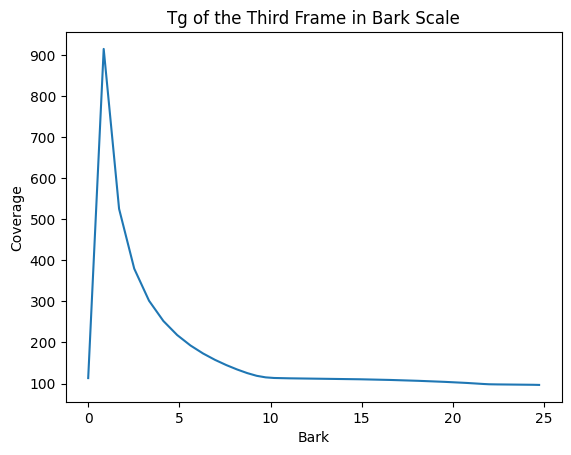

In [ ]:
# Step 1.5: Global masking Threshold

def Tg(Tq, TTM, TNM):
    min_length = min(len(Tq), len(TTM), len(TNM))
    tg = np.zeros(min_length)
    for i in range(min_length):
        tg[i] = 10 * np.log10(10**(0.1 * Tq[i]) + np.sum(10**(0.1 * TTM[i][:256])) + np.sum(10**(0.1 * TNM[i][:256])))
    return tg
     

# plot
tg_thrd = Tg(tq_thrd, ttm_thrd, tnm_thrd)
freqs_tg = np.arange(len(tg_thrd)) * (sr / N)
# Μετατροπή συχνότητας σε Bark scale
bark_scale_tg = bark(freqs_tg)


# Plot Tg σε Bark scale
plt.plot(bark_scale_tg, tg_thrd)
plt.xlabel('Bark')
plt.ylabel('Coverage')
plt.title('Tg of the Third Frame in Bark Scale')
plt.show()


In [ ]:
# Προετοιμασία για εύρεση σε όλα τα πλαίσια
num_frames = len(audio_signal) // N
hanning = np.hanning(N)
Tg_all = np.zeros((num_frames, N//2))

# Βρίσκουμε Tg για όλα τα πλαίσια
for m in range(num_frames):
    # PTMc table
    PTMc_m = P_TMc[:, m]
    # PNMc table
    PNMc_m = P_NMc[:, m]
    # Υπολογισμός Tq 
    m_frame_ps = compute_power_spectrum(frames_windowed[:,m])
    tq_m = Tq(m_frame_ps)
    # SF τονικής μάσκας 
    sf_tm_m = sf(PTMc_m)
    # SF μάσκας θορύβου 
    sf_nm_m = sf(PNMc_m)
    ttm_m = ttm(sf_tm_m, PTMc_m)
    tnm_m = tnm(sf_nm_m, PNMc_m)
    # Υπολογισμός Tg
    Tg_all[m, :] = Tg(tq_m, ttm_m, tnm_m)
